In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Input
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [ ]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/Alzheimer_s Dataset'
train_dir = os.path.join(dataset_path, 'train/')


In [ ]:
print(train_dir)


/content/drive/MyDrive/Alzheimer_s Dataset/train/


In [ ]:

print("Working Directory Contents:", os.listdir(train_dir))


Working Directory Contents: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']


In [ ]:
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=train_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


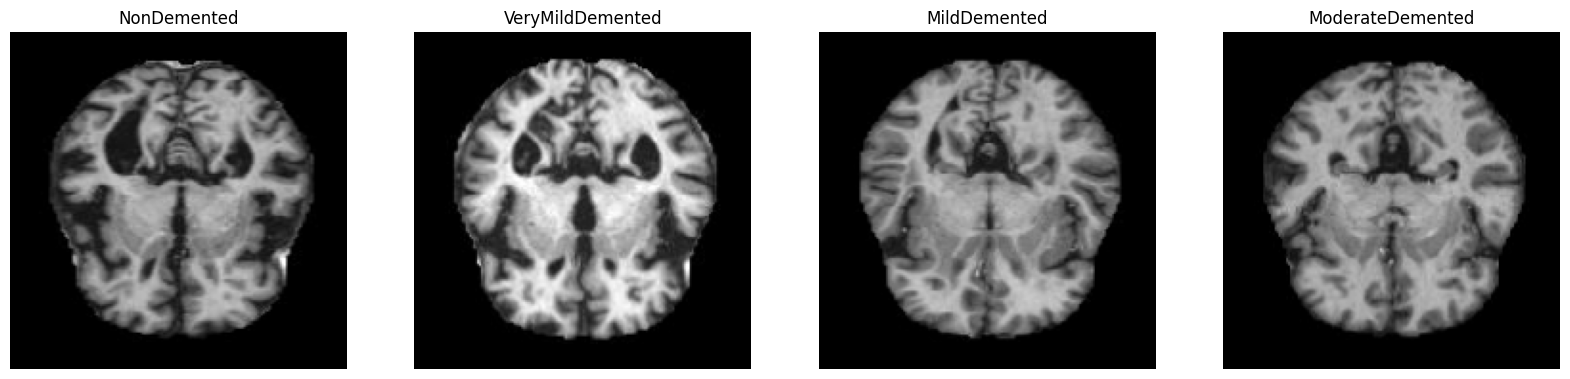

In [ ]:

def display_one_image_per_class(data_gen, classes):
    """
    Displays one image per class with the correct labels.

    Parameters:
    - data_gen: ImageDataGenerator instance.
    - classes: List of class names.
    """
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 20))

    # Ensure the data generator is iterated
    data_iter = data_gen.__iter__()

    for i, class_name in enumerate(classes):
        for batch in data_iter:
            images, labels = batch
            class_index = classes.index(class_name)
            if np.argmax(labels, axis=1).tolist().count(class_index) > 0:
                idx = np.argmax(labels, axis=1).tolist().index(class_index)
                ax = axes[i]
                ax.imshow(images[idx])
                ax.set_title(class_name)
                ax.axis('off')
                break

# Assuming you have the classes and the data generator defined
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
display_one_image_per_class(train_data_gen, CLASSES)


In [ ]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [ ]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)


(10240, 176, 176, 3) (10240, 4)


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

Train data shape: (6553, 176, 176, 3), Train labels shape: (6553, 4)
Validation data shape: (1639, 176, 176, 3), Validation labels shape: (1639, 4)
Test data shape: (2048, 176, 176, 3), Test labels shape: (2048, 4)


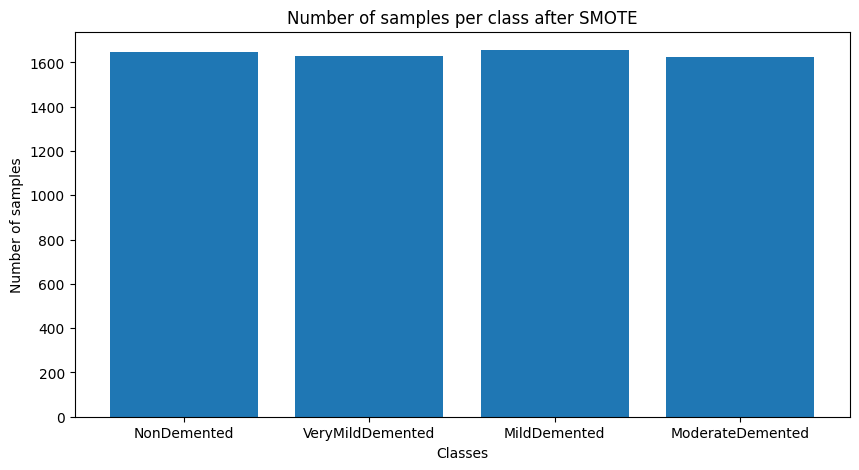

In [ ]:
# Count the number of samples per class
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
class_counts = dict(zip(CLASSES, counts))

# Plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class after SMOTE')
plt.show()


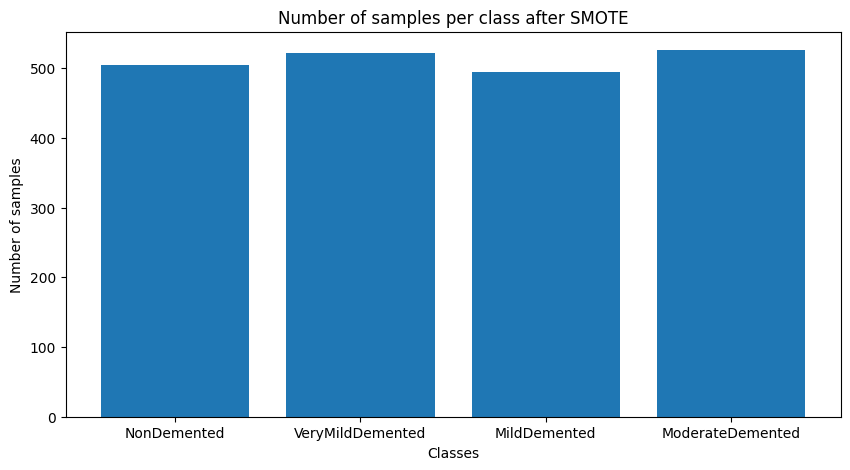

In [ ]:
# Count the number of samples per class
unique, counts = np.unique(np.argmax(test_labels, axis=1), return_counts=True)
class_counts = dict(zip(CLASSES, counts))

# Plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class after SMOTE')
plt.show()


In [ ]:
# Construct Model
model = Sequential([
    Input(shape=(176, 176, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2),

    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(4, activation='softmax')
], name="cnn_model")

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 88, 88, 32)        128       
 Normalization)                                          

In [ ]:
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 1077s 4s/step - loss: 1.6631 - accuracy: 0.2919 - val_loss: 2.2906 - val_accuracy: 0.2466
Epoch 2/100
256/256 [==============================] - 1076s 4s/step - loss: 1.1762 - accuracy: 0.4628 - val_loss: 1.1986 - val_accuracy: 0.4287
Epoch 3/100
256/256 [==============================] - 1086s 4s/step - loss: 0.8469 - accuracy: 0.6151 - val_loss: 2.4763 - val_accuracy: 0.2461
Epoch 4/100
256/256 [==============================] - 1071s 4s/step - loss: 0.7297 - accuracy: 0.6649 - val_loss: 0.7599 - val_accuracy: 0.6226
Epoch 5/100
256/256 [==============================] - 1061s 4s/step - loss: 0.6545 - accuracy: 0.7013 - val_loss: 0.8674 - val_accuracy: 0.6230
Epoch 6/100
256/256 [==============================] - 1180s 5s/step - loss: 0.6040 - accuracy: 0.7310 - val_loss: 4.0527 - val_accuracy: 0.2441
Epoch 7/100
256/256 [==============================] - 1143s 4s/step - loss: 0.5423 - accuracy: 0.7573 - val_loss: 2.8812 - val_ac

KeyboardInterrupt: 

In [ ]:
# Save the model after stopping the training
model.save('/content/drive/MyDrive/p_model.h5')

NameError: name 'model' is not defined

In [ ]:
model = load_model('/content/drive/MyDrive/p_model.h5')

In [ ]:
EPOCHS = 70

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)


Epoch 1/70
256/256 [==============================] - 107s 409ms/step - loss: 0.1995 - accuracy: 0.9355 - val_loss: 0.1552 - val_accuracy: 0.9429
Epoch 2/70
256/256 [==============================] - 101s 394ms/step - loss: 0.0953 - accuracy: 0.9670 - val_loss: 0.1703 - val_accuracy: 0.9346
Epoch 3/70
256/256 [==============================] - 101s 393ms/step - loss: 0.0889 - accuracy: 0.9681 - val_loss: 0.1424 - val_accuracy: 0.9536
Epoch 4/70
256/256 [==============================] - 100s 391ms/step - loss: 0.0739 - accuracy: 0.9736 - val_loss: 0.4657 - val_accuracy: 0.8574
Epoch 5/70
256/256 [==============================] - 99s 387ms/step - loss: 0.0690 - accuracy: 0.9764 - val_loss: 1.0496 - val_accuracy: 0.7295
Epoch 6/70
256/256 [==============================] - 97s 381ms/step - loss: 0.0697 - accuracy: 0.9764 - val_loss: 0.3921 - val_accuracy: 0.8726
Epoch 7/70
256/256 [==============================] - 97s 381ms/step - loss: 0.0576 - accuracy: 0.9818 - val_loss: 0.4532 - va

In [ ]:

test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

64/64 [==============================] - 3s 47ms/step - loss: 0.1938 - accuracy: 0.9492
Testing Accuracy: 94.92%


In [ ]:
pred_labels = model.predict(test_data)

64/64 [==============================] - 3s 44ms/step


In [ ]:

def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.92      0.99      0.95       505
VeryMildDemented       1.00      1.00      1.00       522
    MildDemented       0.94      0.92      0.93       495
ModerateDemented       0.93      0.89      0.91       526

       micro avg       0.95      0.95      0.95      2048
       macro avg       0.95      0.95      0.95      2048
    weighted avg       0.95      0.95      0.95      2048
     samples avg       0.95      0.95      0.95      2048



In [ ]:
model.save('/content/drive/MyDrive/p_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
